In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(imputeLCMD)
    library(limma)
    library(ggplot2)
    library(ggsci)
    library(patchwork)
    library(rrcovNA)
    library(ggExtra)

})

options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}


fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}


devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

ℹ Loading msImpute



In [2]:
ups_data <- read.table("~/softImpute_low_rank_experimentation/data/Cox2014_DDA_MaxQuant_evidence.txt", 
                     sep="\t", header=TRUE)

ups_data <- ups_data[grep("CON__|REV__", ups_data$Leading.Razor.Protein, invert=TRUE),]
table(ups_data$Charge != 1)
ups_data <- ups_data[ups_data$Charge != 1,]

ups_data$PeptideID <- paste(gsub('_' , '', ups_data$Modified.sequence), ups_data$Charge, ups_data$Leading.Razor.Protein, sep="_")


# confirm UPS peptides are in the expression matrix

y <- evidenceToMatrix(ups_data)

keep <- rowSums(!is.na(y)) >= 4
table(keep)

y <- y[keep,]
y <- log2(y)
y_dda <- y

table(grepl("ups", rownames(y_dda)))

group <- gsub("20130510_EXQ1_IgPa_QC_(.*)_0[1-4]",
              "\\1",
              colnames(y_dda))


 FALSE   TRUE 
  6134 356047 

keep
FALSE  TRUE 
 4674 30914 


FALSE  TRUE 
29793  1121 

### Imputation (barycenter + SOTA methods)

In [3]:
y_msImpute <- msImpute(y_dda, 
                       rank.max = 2,
                       method = "v2-mnar", 
                       group = group)


library(MSstats)
#### msStats####
proteinGroups<-read.table("~/softImpute_low_rank_experimentation/data/Cox2014_DDA_MaxQuant_proteinGroups.txt",
                          sep="\t", header=TRUE)

# Read in MaxQuant file: evidence.txt
infile <- read.table("~/softImpute_low_rank_experimentation/data/Cox2014_DDA_MaxQuant_evidence.txt", 
                     sep="\t", header=TRUE)

# Read in annotation including condition and biological replicates
annot <- read.csv("~/softImpute_low_rank_experimentation/data/Cox2014_DDA_MaxQuant_annotation.csv", header=TRUE)


quant <- MaxQtoMSstatsFormat(evidence=infile, annotation=annot, proteinGroups=proteinGroups,
                             useUniquePeptide = TRUE,
                             summaryforMultipleRows = max,
                             removeProtein_with1Peptide=TRUE)


processed.quant <- dataProcess(quant,
                               normalization = 'equalizeMedians',
                               summaryMethod="TMP",
                               cutoffCensored="minFeature",
                               censoredInt="NA",
                               MBimpute=TRUE,
                               maxQuantileforCensored=0.999)

y_msstats <- processed.quant$ProcessedData
y_msstats$peptide_id <- paste0(y_msstats$PEPTIDE,'_', y_msstats$PROTEIN)
y_msstats <- y_msstats[,c('peptide_id', 'originalRUN', 'ABUNDANCE')]
y_msstats <- tidyr::spread(y_msstats, 'originalRUN', 'ABUNDANCE')
rownames(y_msstats) <- y_msstats$peptide_id
y_msstats$peptide_id <- NULL



y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)




y_perseus <- impute.perseus(y_dda)

# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]


sOa_imps <- readRDS("~/softImpute_low_rank_experimentation/impute_PXD000279_sOa_filter4obs_noNorm_MassIVquant.rds")

names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])


all(rownames(y_dda) == rownames(sOa_imps[[1]]))

mats <- list(
             "KNN"= y_knn,
             "impSeq" = y_impSeq,
             "barycenter" = y_msImpute,
             "MSstats_AFT" = y_msstats,
             "baseline" = y_dda)


mats <- c(sOa_imps, mats)

Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 5.03504276178782

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar

** + Contaminant, + Reverse, + Only.identified.by.site, proteins are removed.

** Peptide and charge, that have 1 or 2 measurements across runs, are removed.

** 122 proteins, which have only peptide and charge in a protein, are removed among 2207 proteins.

** Log2 intensities under cutoff = 19.492  were considered as censored missing values.

** Log2 intensities = NA were considered as censored missing values.

** Use all features that the dataset origianally has.



                       
  Summary of Features :
                         count
# of Protein              2085
# of Peptides/Protein    2-134
# of Transitions/Peptide   1-1
                      
  Summary of Samples :
                           UPS1 UPS2
# of MS runs                  4    4
# of Biological Replicates    1    1
# of Technical Replicates     4    4



 Summary of Missingness :


  # transitions are completely missing in at least one of the conditions : 862


    -> DPAATSVAAAR_2_NA_NA, FLTPCYHPNVDTQGNICLDILK_2_NA_NA, FLTPCYHPNVDTQGNICLDILK_3_NA_NA, LSLEFPSGYPYNAPTVK_2_NA_NA, RLQQELM(ox)TLM(ox)M(ox)SGDK_2_NA_NA ...


  # run with 75% missing observations: 0



 == Start the summarization per subplot...



  |======================================================================| 100%



 == the summarization per subplot is done.



Cluster size 30914 broken into 9509 21405 
Cluster size 9509 broken into 4526 4983 
Cluster size 4526 broken into 2933 1593 
Cluster size 2933 broken into 1135 1798 
Done cluster 1135 
Cluster size 1798 broken into 1563 235 
Cluster size 1563 broken into 470 1093 
Done cluster 470 
Done cluster 1093 
Done cluster 1563 
Done cluster 235 
Done cluster 1798 
Done cluster 2933 
Cluster size 1593 broken into 172 1421 
Done cluster 172 
Done cluster 1421 
Done cluster 1593 
Done cluster 4526 
Cluster size 4983 broken into 2680 2303 
Cluster size 2680 broken into 972 1708 
Done cluster 972 
Cluster size 1708 broken into 1204 504 
Done cluster 1204 
Done cluster 504 
Done cluster 1708 
Done cluster 2680 
Cluster size 2303 broken into 1428 875 
Done cluster 1428 
Done cluster 875 
Done cluster 2303 
Done cluster 4983 
Done cluster 9509 
Cluster size 21405 broken into 9772 11633 
Cluster size 9772 broken into 796 8976 
Done cluster 796 
Cluster size 8976 broken into 412 8564 
Done cluster 412 
C

[1] TRUE

### Differential Expression

In [4]:

design <- model.matrix(~ group)

n_ups <- 500
fdr_thresh <- 0.05


topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   if(names(mats)[i] != "MSstats_AFT"){
     E <- normalizeBetweenArrays(mats[[i]], method = "quantile")
   }else{
     E <- mats[[i]]
   }
  

   fit <- lmFit(E, design = design)
   
   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < fdr_thresh,1,0)
  tp$isUPS <- ifelse(grepl("ups", rownames(tp)),1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$FN_unestim <- ifelse(is.na(tp$adj.P.Val) & tp$isUPS==1,1,0)
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > fdr_thresh)[1],1,0),
                                       method=names(mats)[i])
  


  fullTables[[names(mats)[i]]] <- data.frame(

    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(
    

    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE),
    FN_unestim_total = sum(tp$FN_unestim, na.rm = TRUE)
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))
fullTables$predictions[is.na(fullTables$predictions)] <- 0

fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))


processing RF



       (Intercept) groupUPS2
Down             0       345
NotSig           0     30433
Up           30914       136


processing Mice



       (Intercept) groupUPS2
Down             0       164
NotSig           0     30632
Up           30914       118


processing EM



       (Intercept) groupUPS2
Down             0       157
NotSig           0     30635
Up           30914       122


processing BPCA



       (Intercept) groupUPS2
Down             0       103
NotSig           0     30703
Up           30914       108


processing KNN



       (Intercept) groupUPS2
Down             0       271
NotSig           0     30553
Up           30914        90


processing impSeq



       (Intercept) groupUPS2
Down             0       158
NotSig           0     30635
Up           30914       121


processing barycenter



       (Intercept) groupUPS2
Down             0       778
NotSig           0     29750
Up           30914       386


processing MSstats_AFT



       (Intercept) groupUPS2
Down             0       197
NotSig           0     31760
Up           32898        79


processing baseline



       (Intercept) groupUPS2
Down             0       206
NotSig           0     29986
Up           30914       130


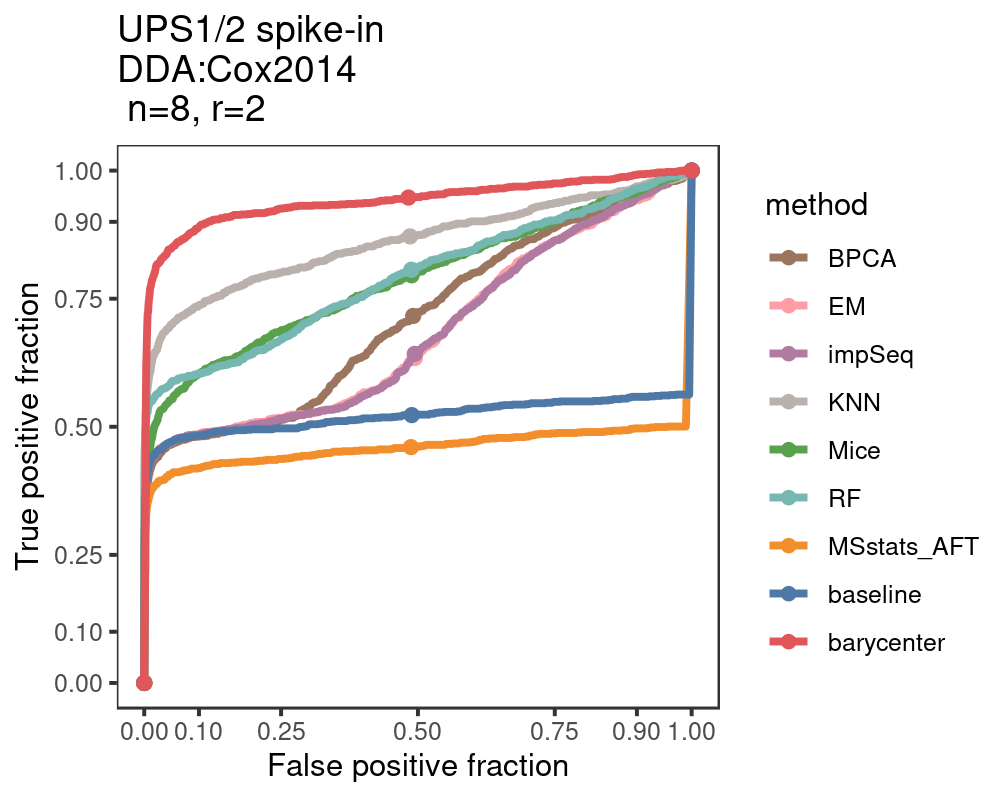

In [5]:
fig.size(4, 5)


library(plotROC)
library(patchwork)
library(ggthemes)

col_pal <- tableau_color_pal(palette = "Tableau 10", direction = -1)(9)
col_pal[col_pal == "#EDC948"] = "#BAB0AC"
names(col_pal) <- c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","barycenter","MSstats_AFT","baseline")


fullTables$method <- factor(fullTables$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF",
                                        "MSstats_AFT",
                                        "baseline","barycenter"))

p2 <- ggplot(fullTables, aes(m = predictions, d = labels, group = method, color = method))+ geom_roc(n.cuts=3,labels=FALSE) +
   style_roc(guide = FALSE) + 
  scale_color_manual(values = col_pal) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()  
        #legend.position = "none"
       )
  





fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF",
                                        "MSstats_AFT",
                                        "baseline","barycenter"))


dataset_name = 'PXD000279'

print(p2 + labs(title = "UPS1/2 spike-in \nDDA:Cox2014\n n=8, r=2"))

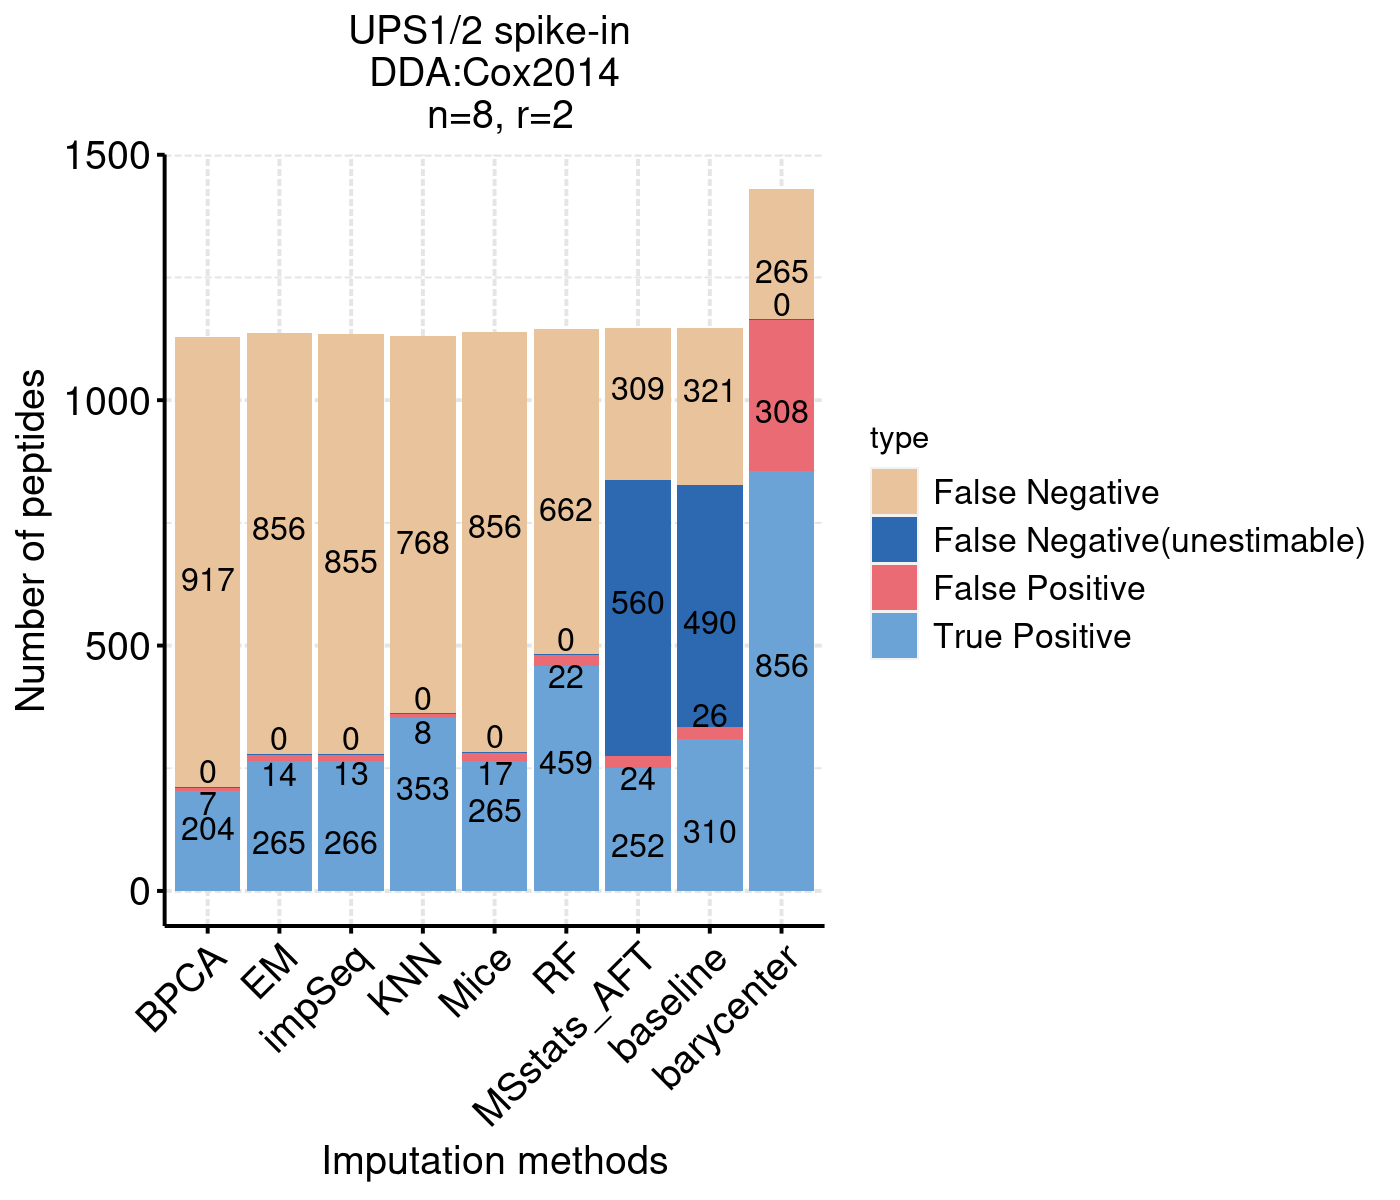

In [6]:
fig.size(6,7)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05
ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub('FN_unestim', 'False Negative(unestimable)', ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  ggrepel::geom_text_repel(size = 4, 
            position = position_stack(vjust = 0.5), direction = "y", 
            box.padding = unit(0.01, "lines")) + 
  xlab('Imputation methods') + ylab('Number of peptides') + 
  labs(fill="type", title = "UPS1/2 spike-in \nDDA:Cox2014\n n=8, r=2") +  

  scale_fill_manual(values = c('False Negative(unestimable)' = "#2c69b0",
                               'False Negative' = "#e9c39b" ,
                               'True Positive' = "#6ba3d6", 
                               'False Positive' = "#ea6b73")) + 
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12),
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p


FALSE  TRUE 
30322   592 

png 
  2

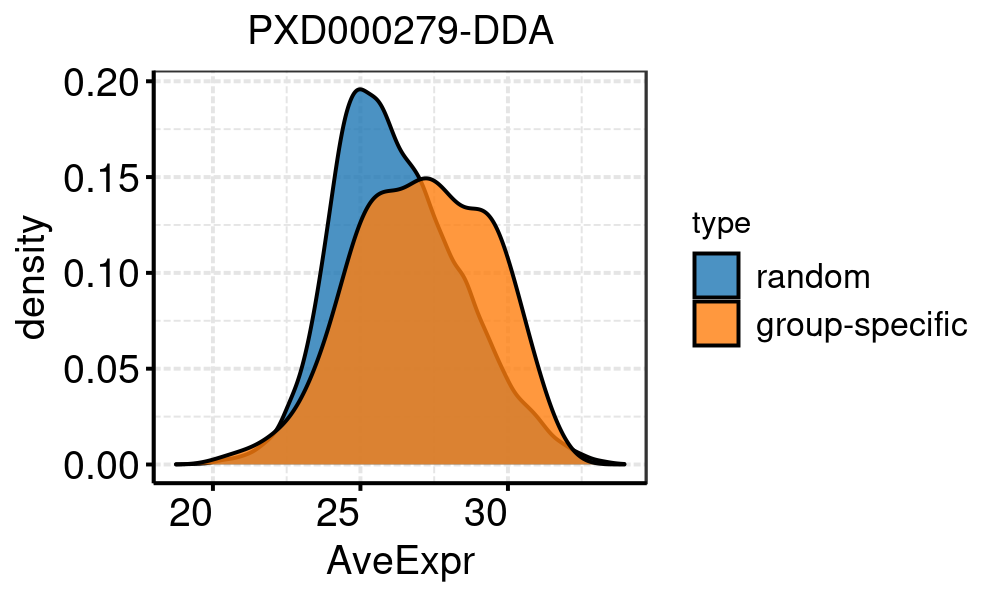

In [7]:
fig.size(3,5)

# Visualization of the ebm metric for assessment of missing types
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)




ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


png(file = "~/hist_missingtype_PXD000279.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD000279-DDA")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

print(p)
dev.off()
p

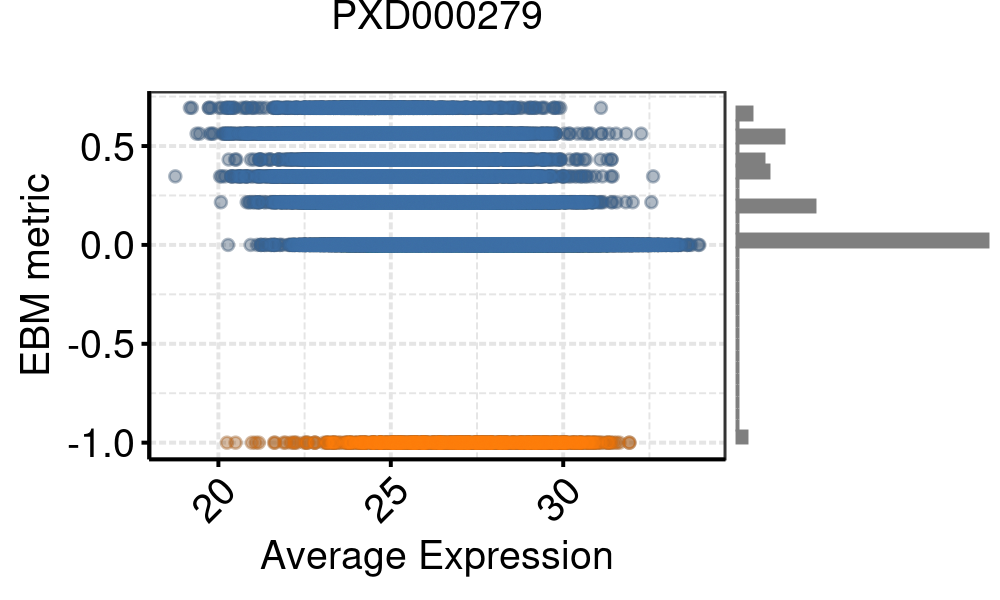

In [8]:
fig.size(3,5)

p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average Expression', y = 'EBM metric', title='PXD000279')

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)



# png(file = "~/scatter_ebm_abundance_PXD000279.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()


p1 


FALSE  TRUE 
30322   592 

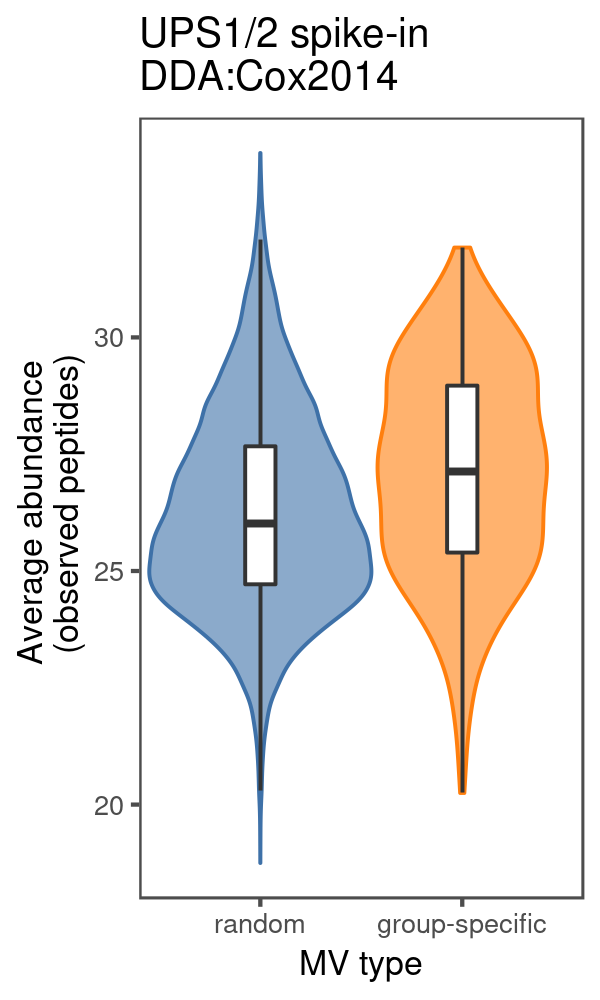

In [9]:
fig.size(5,3)
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)



library(ggExtra)
library(ggthemes)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))



# png(file = paste0("revision_figures/violin_",dataset_name,".png"),
#     width=3.5,height=5.55, units="in",res=300)
pv <- ggplot(ggdat, aes(x=type, y = AveExpr)) + 
  geom_violin(aes(fill = type, color = type), alpha = 0.6, width = 1.1, show.legend = FALSE) +
  # stat_summary(fun.data=mean_sdl,
  #                geom="pointrange", color="black") +
  geom_boxplot(width=0.15, outlier.shape = NA) + 
  scale_fill_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  scale_color_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  labs(fill = '', y = 'Average abundance \n (observed peptides)', x = 'MV type',
       title = "UPS1/2 spike-in \nDDA:Cox2014") +
  theme_few() 

print(pv)
# dev.off()

### Session information

In [10]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggthemes_4.2.4      plotROC_2.2.1       MSstats_3.22.1     
 [4] msImpute_1.7.1      ggExtra_0.9         rrcovNA_0.4-15     
 [7] rrcov_1.6-0         robustbase_0.93-7   patchwork_1.1.1    
[10] ggsci_2.9        